In [1]:
from pathlib import Path
import sys

BASE_PATH = Path('../')
PATH_TO_DATA = BASE_PATH/'data'
PATH_TO_MODELS = BASE_PATH/'checkpoints'
PATH_TO_CACHE = BASE_PATH/'cache'
PATH_TO_LOGS = BASE_PATH/'logs'

PATH_TO_CACHE.mkdir(exist_ok=True, parents=True)
PATH_TO_DATA.mkdir(exist_ok=True, parents=True)
PATH_TO_MODELS.mkdir(exist_ok=True, parents=True)
PATH_TO_LOGS.mkdir(exist_ok=True, parents=True)


sys.path.append(str(BASE_PATH/'..'))

#### <b>Load Libraries</b>

In [51]:
import pprint
from copy import deepcopy
from tqdm import tqdm
import time
import random
from pathlib import Path
import pickle

from PIL import Image

import numpy as np
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from torchvision import models
from torchvision import transforms
from torchvision.datasets import CIFAR10

from torch.utils.data import Dataset, DataLoader, Subset

from utils import progress_bar, load_model

#### <b>Notebook Constants</b>

In [3]:
RANDOM_STATE = 42
BATCH_SIZE = 256
NUM_WORKERS = 4
DEVICE = 'cuda'
NUM_CLASSES = 10

In [4]:
def set_random_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

#### <b>Define Custom Dataset</b>

In [5]:
train_transforms = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

cifar10_aug = CIFAR10(root=PATH_TO_DATA, train=True, transform=train_transforms)
cifar10 = CIFAR10(root=PATH_TO_DATA, train=True, transform=test_transforms)

test_dataset = CIFAR10(root=PATH_TO_DATA, train=False, transform=test_transforms)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

In [6]:
train_inds = np.load(PATH_TO_DATA/'train_inds.npy')
unseen_inds = np.load(PATH_TO_DATA/'unseen_inds.npy')
retain_inds = np.load(PATH_TO_DATA/'retain_inds.npy')
forget_inds = np.load(PATH_TO_DATA/'forget_inds.npy')
shadow_inds = np.load(PATH_TO_DATA/'shadow_inds.npy')


with open(PATH_TO_DATA/'data_split.pickle', 'rb') as file:
    data_split = pickle.load(file)

#### <b>Evalution utils</b>

In [7]:
def downstream_task_performance(model, dataloader):
    model.eval()
    top2_correct = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(dataloader):
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            outputs = model(inputs)

            _, preds = outputs.max(1)
            total += targets.size(0)
            correct += preds.eq(targets).sum().item()

            # Top-2 accuracy.
            _, top2_preds = outputs.topk(2, dim=1)
            top2_correct += top2_preds.eq(targets.view(-1, 1).expand_as(top2_preds)).any(dim=1).sum().item()

            progress_bar(batch_idx, len(dataloader), f'Acc: {100*correct/total:.2f}%%% Top2 Acc: {100*top2_correct/total:.2f}%%%')
    
    return 100*correct/total, 100*top2_correct/total

In [8]:
from MIA.score import get_logits, lira_offline, lira_online

def lira(target_net, train_inds, forget_inds, data_split, cached=True):

    num_aug = 1
    fix_variance = False

    if num_aug > 1:
        dataset = Subset(cifar10_aug, train_inds)
    else:
        dataset = Subset(cifar10, train_inds)
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
    labels = np.int64(~np.isin(train_inds, forget_inds))
    masks_in = [np.array(data_split[x]) for x in train_inds]
    
    if cached and (PATH_TO_CACHE/'shadow_logits.npy').is_file():
        shadow_logits = np.load(PATH_TO_CACHE/'shadow_logits.npy')
        print('Shadow logits were brought from cache')
    else:
        shadow_nets = [load_model(state_dict, NUM_CLASSES).to(DEVICE) for state_dict in (PATH_TO_MODELS/'shadow').glob('*/*')]
        shadow_logits = []
        for _ in range(num_aug):
            dataset_labels = []
            shadow_aug_logits = [[] for _ in range(len(shadow_nets))]
            with torch.no_grad():
                for batch_idx, (inputs, targets) in tqdm(enumerate(dataloader), total=len(dataloader)):
                    inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

                    for i, net in enumerate(shadow_nets):
                        logits = net(inputs).cpu().tolist()
                        shadow_aug_logits[i].append(logits)
                
                    dataset_labels.append(targets.cpu().tolist())

            shadow_aug_logits = np.stack([np.concatenate(logits) for logits in shadow_aug_logits])  # [n_shadow, n_examples, n_classes]
            dataset_labels = np.concatenate(dataset_labels)[:, None]  # [n_examples, 1]

            # Extract numerically stable logits
            shadow_aug_logits = get_logits(shadow_aug_logits, np.repeat(dataset_labels[None], len(shadow_nets), 0))
            shadow_logits.append(shadow_aug_logits)
        
        shadow_logits = np.stack(shadow_logits, axis=-1)
        shadow_logits = np.swapaxes(shadow_logits, 0, 1)  # [n_examples, n_shadow, n_aug]
        np.save(PATH_TO_CACHE/'shadow_logits.npy', shadow_logits)
    
    target_logits = []
    for _ in range(num_aug):
        dataset_labels = []
        target_aug_logits = []
        with torch.no_grad():
            for batch_idx, (inputs, targets) in tqdm(enumerate(dataloader), total=len(dataloader)):
                inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

                logits = target_net(inputs).cpu().tolist()
                target_aug_logits.append(logits)
        
                dataset_labels.append(targets.cpu().tolist())
            
        
        target_aug_logits = np.concatenate(target_aug_logits)  # [n_examples, n_classes]
        dataset_labels = np.concatenate(dataset_labels)[:, None]  # [n_examples, 1]

        # Extract numerically stable logits
        target_aug_logits = get_logits(target_aug_logits, dataset_labels)

        target_logits.append(target_aug_logits)

    target_logits = np.stack(target_logits, axis=-1)  # [n_examples, n_aug]

    fnr, tnr, auc, low = lira_online(target_logits, shadow_logits, labels, masks_in, fix_variance=fix_variance)

    return fnr, tnr, auc, low

In [9]:
def evaluate_unlearning(model, forget_inds, retain_inds):

    global cifar10, train_inds, data_split, unseen_inds, test_dataloader

    unseen_dataset = Subset(cifar10, unseen_inds)
    unseen_dataloader = DataLoader(unseen_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

    forget_dataset = Subset(cifar10, forget_inds)
    forget_dataloader = DataLoader(forget_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

    retain_dataset = Subset(cifar10, retain_inds)
    retain_dataloader = DataLoader(retain_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

    model.eval()
    
    retain_acc = downstream_task_performance(model, retain_dataloader)
    forget_acc = downstream_task_performance(model, forget_dataloader)
    test_acc = downstream_task_performance(model, test_dataloader)
    unseen_acc = downstream_task_performance(model, unseen_dataloader)
    fnr, tnr, auc, low = lira(model, train_inds, forget_inds, data_split)

    result_df = pd.DataFrame(
            index=[
                'retain_acc',
                'forget_acc',
                'test_acc',
                'unseen_acc',
                'MIA_AUC','MIA_TNR@1%FNR'
            ],
            data=[
                np.round(retain_acc[0], 2),
                np.round(forget_acc[0], 2),
                np.round(test_acc[0], 2),
                np.round(unseen_acc[0], 2),
                np.round(100*auc, 2),
                np.round(100*low, 2)
            ]
            ).T

    return result_df, fnr, tnr


#### <b>Evaluate origin model</b>

 [=======================================>]  Step: 27ms | Tot: 604ms | Acc: 89.05%%% Top2 Acc: 96.75% 84/84 
 [================================>.......]  Step: 27ms | Tot: 39ms | Acc: 89.16%%% Top2 Acc: 96.80% 5/5 
 [=======================================>]  Step: 29ms | Tot: 290ms | Acc: 75.21%%% Top2 Acc: 88.86% 40/40 
 [======================================>.]  Step: 25ms | Tot: 149ms | Acc: 75.70%%% Top2 Acc: 90.22% 20/20 
Shadow logits were brought from cache


100%|██████████| 88/88 [00:00<00:00, 103.76it/s]


,retain_acc,forget_acc,test_acc,unseen_acc,MIA_AUC,MIA_TNR@1%FNR
0,89.05,89.16,75.21,75.7,49.84,1.07


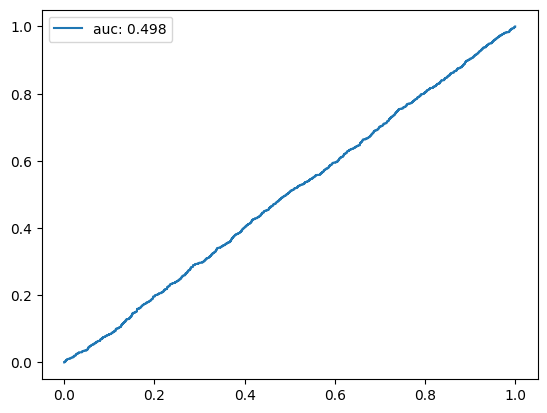

In [10]:
model = load_model(PATH_TO_MODELS/'origin'/'state_dict.pth', NUM_CLASSES)
model.to(DEVICE)

df_metrics, fnr, tnr = evaluate_unlearning(model, forget_inds, retain_inds)
 
display(df_metrics)

plt.plot(fnr, tnr, label=f'auc: {metrics.auc(fnr, tnr):.3f}')
plt.legend()

#### <b>Evaluate retrained model</b>

 [=======================================>]  Step: 4ms | Tot: 596ms | Acc: 90.18%%% Top2 Acc: 97.01% 84/84  
 [================================>.......]  Step: 4ms | Tot: 16ms | Acc: 74.93%%% Top2 Acc: 89.69% 5/5  
 [=======================================>]  Step: 2ms | Tot: 272ms | Acc: 75.93%%% Top2 Acc: 89.24% 40/40  ================================>.......]  Step: 16ms | Tot: 234ms | Acc: 75.88%%% Top2 Acc: 89.17% 33/40 
 [======================================>.]  Step: 3ms | Tot: 124ms | Acc: 76.06%%% Top2 Acc: 89.86% 20/20  
Shadow logits were brought from cache


100%|██████████| 88/88 [00:00<00:00, 128.24it/s]


,retain_acc,forget_acc,test_acc,unseen_acc,MIA_AUC,MIA_TNR@1%FNR
0,90.18,74.93,75.93,76.06,68.88,9.6


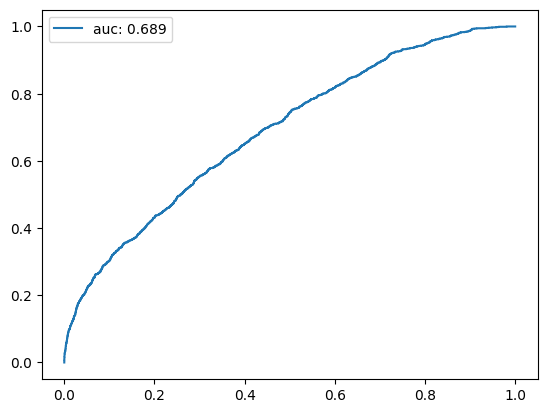

In [11]:
model = load_model(PATH_TO_MODELS/'retrained'/'state_dict.pth', NUM_CLASSES)
model.to(DEVICE)

df_metrics, fnr, tnr = evaluate_unlearning(model, forget_inds, retain_inds)
 
display(df_metrics)

plt.plot(fnr, tnr, label=f'auc: {metrics.auc(fnr, tnr):.3f}')
plt.legend()

#### <b>Unlearning</b>

##### <b>Fine Tuning</b>

In [12]:
def fine_tune_unlearning(model, forget_inds, retain_inds, unseen_inds):

    set_random_seed(RANDOM_STATE)
    
    model.train()
    
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01)

    dataset = Subset(cifar10_aug, retain_inds)
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)

    num_epochs = 10
    for epoch in range(num_epochs):
        for inputs, targets in tqdm(dataloader, desc=f'epoch {epoch}/{num_epochs}', leave=False):
            
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    model.eval()

 [=======================================>]  Step: 3ms | Tot: 606ms | Acc: 89.41%%% Top2 Acc: 96.93% 84/84   ======================>.................]  Step: 16ms | Tot: 358ms | Acc: 89.36%%% Top2 Acc: 96.88% 49/84 ====================================>...]  Step: 17ms | Tot: 567ms | Acc: 89.48%%% Top2 Acc: 96.98% 77/84 
 [========================>...............]  Step: 4ms | Tot: 12ms | Acc: 88.28%%% Top2 Acc: 96.39% 4/5  ================================>.......]  Step: 28ms | Tot: 40ms | Acc: 88.80%%% Top2 Acc: 96.53% 5/5 
 [=======================================>]  Step: 26ms | Tot: 304ms | Acc: 75.19%%% Top2 Acc: 88.81% 40/40 
 [======================================>.]  Step: 26ms | Tot: 154ms | Acc: 75.82%%% Top2 Acc: 89.90% 20/20 
Shadow logits were brought from cache


100%|██████████| 88/88 [00:00<00:00, 114.96it/s]


,retain_acc,forget_acc,test_acc,unseen_acc,MIA_AUC,MIA_TNR@1%FNR,unlearning_time
0,89.41,88.8,75.19,75.82,50.95,1.42,12


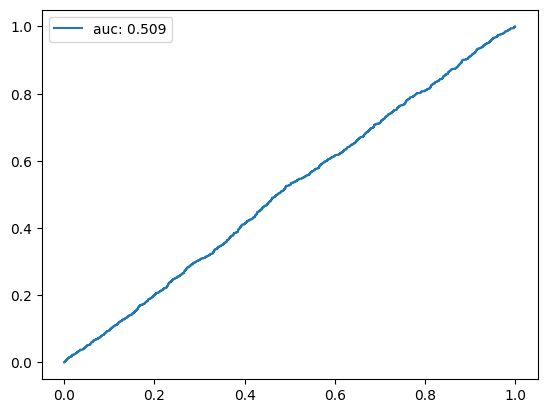

In [13]:
model = load_model(PATH_TO_MODELS/'origin'/'state_dict.pth', NUM_CLASSES)
model.to(DEVICE)

start = time.time()
fine_tune_unlearning(model, forget_inds, retain_inds, unseen_inds)
unlearning_time = time.time() - start

df_metrics, fnr, tnr = evaluate_unlearning(model, forget_inds, retain_inds)
df_metrics['unlearning_time'] = round(unlearning_time)
display(df_metrics)

plt.plot(fnr, tnr, label=f'auc: {metrics.auc(fnr, tnr):.3f}')
plt.legend()

##### <b>Fine Tuning with random labels</b>

In [46]:
def random_labels_unlearning(model, forget_inds, retain_inds, unseen_inds):

    set_random_seed(RANDOM_STATE)

    class CustomDataset(Dataset):
        def __init__(self, inds, targets):
            self.dataset = Subset(cifar10_aug, inds)
            self.targets = targets

        def __len__(self):
            return len(self.dataset)

        def __getitem__(self, index):
            return self.dataset[index][0], self.targets[index]

    inds = np.concatenate([retain_inds, forget_inds])
    targets = np.concatenate([np.array(cifar10_aug.targets)[retain_inds], np.random.randint(0, NUM_CLASSES, size=len(forget_inds))])

    dataset = CustomDataset(inds, targets)
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)

    model.train()
    model.to(DEVICE)
    
    CE = torch.nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=5e-4)

    num_epochs = 10
    for epoch in range(num_epochs):
        for inputs, labels in tqdm(dataloader, desc=f'epoch {epoch}/{num_epochs}', leave=False):
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            outputs = model(inputs)
            loss = CE(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    model.eval()

 [=======================================>]  Step: 3ms | Tot: 630ms | Acc: 87.80%%% Top2 Acc: 96.50% 84/84  
 [================================>.......]  Step: 4ms | Tot: 17ms | Acc: 76.44%%% Top2 Acc: 89.96% 5/5  
 [=======================================>]  Step: 3ms | Tot: 280ms | Acc: 74.06%%% Top2 Acc: 88.12% 40/40  
 [======================================>.]  Step: 3ms | Tot: 126ms | Acc: 74.82%%% Top2 Acc: 89.06% 20/20  
Shadow logits were brought from cache


100%|██████████| 88/88 [00:00<00:00, 120.26it/s]


,retain_acc,forget_acc,test_acc,unseen_acc,MIA_AUC,MIA_TNR@1%FNR,unlearning_time
0,87.8,76.44,74.06,74.82,63.03,4.8,12


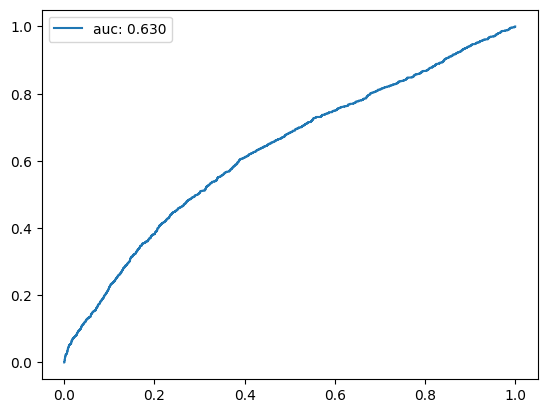

In [47]:
model = load_model(PATH_TO_MODELS/'origin'/'state_dict.pth', NUM_CLASSES)
model.to(DEVICE)

start = time.time()
random_labels_unlearning(model, forget_inds, retain_inds, unseen_inds)
unlearning_time = time.time() - start

df_metrics, fnr, tnr = evaluate_unlearning(model, forget_inds, retain_inds)
df_metrics['unlearning_time'] = round(unlearning_time)
display(df_metrics)

plt.plot(fnr, tnr, label=f'auc: {metrics.auc(fnr, tnr):.3f}')
plt.legend()

##### <b>Fine Tuning with NOT random labels</b>

In [58]:
def not_random_labels_unlearning(model, forget_inds, retain_inds, unseen_inds):

    set_random_seed(RANDOM_STATE)

    feature_extractor = models.convnext_tiny(weights='DEFAULT')
    def get_features(name):
        def hook(model, input, output):
            features[name] = output.detach()
        return hook
    feature_extractor.avgpool.register_forward_hook(get_features('feats'))
    feature_extractor.eval()
    feature_extractor.to(DEVICE)

    model.eval()
    model.to(DEVICE)

    unseen_dataset = Subset(cifar10, unseen_inds)
    unseen_dataloader = DataLoader(unseen_dataset, shuffle=False, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
    forget_dataset = Subset(cifar10, forget_inds)
    forget_dataloader = DataLoader(forget_dataset, shuffle=False, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

    forget_feats = []
    forget_preds = []
    forget_targets = []

    unseen_feats = []
    unseen_preds = []
    unseen_targets = []

    features = {}

    for inputs, targets in tqdm(unseen_dataloader):
        inputs = inputs.to(DEVICE)
        unseen_preds.append(model(inputs).log_softmax(1).detach().cpu())
        feature_extractor(inputs)
        unseen_feats.append(features['feats'].squeeze().cpu())
        unseen_targets.append(targets.detach().cpu())

    unseen_preds = torch.cat(unseen_preds)
    unseen_feats = torch.cat(unseen_feats)
    unseen_targets = torch.cat(unseen_targets)

    for inputs, targets in tqdm(forget_dataloader):
        inputs = inputs.to(DEVICE)
        forget_preds.append(model(inputs).log_softmax(1).detach().cpu())
        feature_extractor(inputs)
        forget_feats.append(features['feats'].squeeze().cpu())
        forget_targets.append(targets.detach().cpu())

    forget_preds = torch.cat(forget_preds)
    forget_feats = torch.cat(forget_feats)
    forget_targets = torch.cat(forget_targets)

    # change targets with closest from unseen
    for i, x in enumerate(forget_feats):
        j = torch.topk(F.cosine_similarity(x, unseen_feats), 1).indices
        forget_preds[i] = unseen_preds[j].mean(axis=0)
        forget_targets[i] = torch.mode(unseen_targets[j]).values

    inds = np.concatenate([retain_inds, forget_inds])
    targets = torch.cat([torch.tensor(cifar10_aug.targets)[retain_inds], forget_targets])

    class CustomDataset(Dataset):
        def __init__(self, inds, targets):
            self.dataset = Subset(cifar10_aug, inds)
            self.targets = targets

        def __len__(self):
            return len(self.dataset)

        def __getitem__(self, index):
            return self.dataset[index][0], self.targets[index]

    dataset = CustomDataset(inds, targets)
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)

    model.train()
    model.to(DEVICE)
    
    CE = torch.nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=5e-4)

    num_epochs = 20
    for epoch in range(num_epochs):
        for inputs, labels in tqdm(dataloader, desc=f'epoch {epoch}/{num_epochs}', leave=False):
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            outputs = model(inputs)
            loss = CE(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    model.eval()

100%|██████████| 5/5 [00:00<00:00, 22.41it/s]


 [=======================================>]  Step: 3ms | Tot: 622ms | Acc: 91.27%%% Top2 Acc: 98.03% 84/84   
 [================================>.......]  Step: 4ms | Tot: 20ms | Acc: 73.33%%% Top2 Acc: 88.98% 5/5  
 [=======================================>]  Step: 3ms | Tot: 280ms | Acc: 74.08%%% Top2 Acc: 88.23% 40/40  
 [======================================>.]  Step: 3ms | Tot: 129ms | Acc: 74.54%%% Top2 Acc: 89.00% 20/20  
Shadow logits were brought from cache


100%|██████████| 88/88 [00:00<00:00, 122.64it/s]


,retain_acc,forget_acc,test_acc,unseen_acc,MIA_AUC,MIA_TNR@1%FNR,unlearning_time
0,91.27,73.33,74.08,74.54,64.44,8.27,26


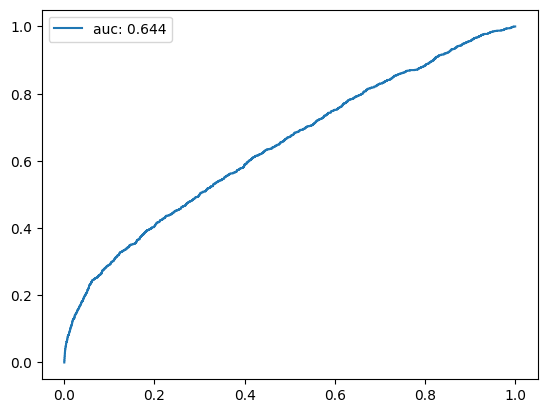

In [59]:
model = load_model(PATH_TO_MODELS/'origin'/'state_dict.pth', NUM_CLASSES)
model.to(DEVICE)

start = time.time()
not_random_labels_unlearning(model, forget_inds, retain_inds, unseen_inds)
unlearning_time = time.time() - start

df_metrics, fnr, tnr = evaluate_unlearning(model, forget_inds, retain_inds)
df_metrics['unlearning_time'] = round(unlearning_time)
display(df_metrics)

plt.plot(fnr, tnr, label=f'auc: {metrics.auc(fnr, tnr):.3f}')
plt.legend()

##### <b>Negative gradient</b>

In [60]:
def neg_grad_unlearning(model, forget_inds, retain_inds, unseen_inds):

    set_random_seed(RANDOM_STATE)
    
    model.train()
    
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01)

    dataset = Subset(cifar10_aug, forget_inds)
    forget_dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)

    dataset = Subset(cifar10_aug, retain_inds)
    retain_dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)

    num_epochs = 10
    for epoch in range(num_epochs):
        for inputs, targets in tqdm(forget_dataloader, desc=f'epoch {epoch}/{num_epochs}', leave=False):
            
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

            outputs = model(inputs)
            loss = -criterion(outputs, targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    for epoch in range(1):
        for inputs, targets in tqdm(retain_dataloader, leave=False):
            
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    model.eval()

 [=======================================>]  Step: 3ms | Tot: 628ms | Acc: 88.58%%% Top2 Acc: 96.66% 84/84   
 [================================>.......]  Step: 3ms | Tot: 16ms | Acc: 87.29%%% Top2 Acc: 95.64% 5/5  
 [=======================================>]  Step: 3ms | Tot: 275ms | Acc: 75.12%%% Top2 Acc: 88.88% 40/40  
 [======================================>.]  Step: 3ms | Tot: 129ms | Acc: 75.22%%% Top2 Acc: 89.60% 20/20  
Shadow logits were brought from cache


100%|██████████| 88/88 [00:00<00:00, 122.30it/s]


,retain_acc,forget_acc,test_acc,unseen_acc,MIA_AUC,MIA_TNR@1%FNR,unlearning_time
0,88.58,87.29,75.12,75.22,52.32,2.13,4


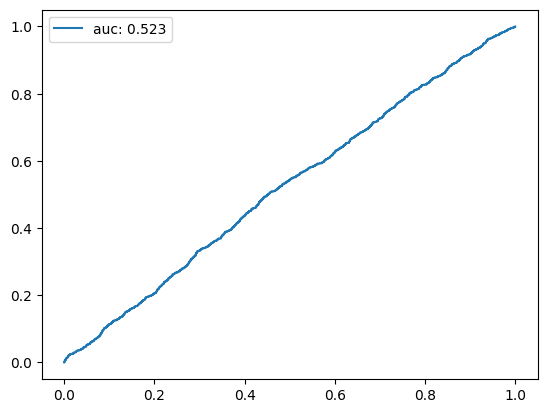

In [61]:
model = load_model(PATH_TO_MODELS/'origin'/'state_dict.pth', NUM_CLASSES)
model.to(DEVICE)

start = time.time()
neg_grad_unlearning(model, forget_inds, retain_inds, unseen_inds)
unlearning_time = time.time() - start

df_metrics, fnr, tnr = evaluate_unlearning(model, forget_inds, retain_inds)
df_metrics['unlearning_time'] = round(unlearning_time)
display(df_metrics)

plt.plot(fnr, tnr, label=f'auc: {metrics.auc(fnr, tnr):.3f}')
plt.legend()

##### <b>UnGAN</b>

In [ ]:
torch.eye(10)[np.random.randint(0, 10)]

In [ ]:
hidden_size=32

class Discriminator(nn.Module):
    def __init__(self, num_classes):
        super(Discriminator, self).__init__()
        # self.class_embeddings = nn.Embedding(num_classes, num_classes)
        self.class_embeddings = torch.eye(num_classes, device=DEVICE)
        
        self.model = nn.Sequential(
            nn.Linear(2*num_classes, hidden_size),
            nn.GELU(),
            nn.Linear(hidden_size, hidden_size),
            nn.GELU(),
            nn.Linear(hidden_size, 1),
        )
        
    def forward(self, logits, label):
        label_emb = self.class_embeddings[label]
        z = torch.hstack([logits, label_emb])
        return self.model(z).flatten()

# class Discriminator(nn.Module):
#     def __init__(self, num_classes):
#         super(Discriminator, self).__init__()
#         # self.class_embeddings = nn.Embedding(num_classes, num_classes)
        
#         self.model = nn.Sequential(
#             nn.Linear(1, 1),
#         )
        
#     def forward(self, logits, label):
#         logits = logits.softmax(1)
#         y_true = logits[range(len(label)), label]
#         logit = torch.log(y_true+1e-45) - torch.log((1 - y_true)+1e-45)

#         return self.model(logit.reshape(-1, 1)).flatten()

class Trainer:
    def __init__(self, model):
        
        self.discriminator = Discriminator(NUM_CLASSES)
        self.model = model
        self.alpha = 0.0

        self.model.cuda()
        self.discriminator.cuda()
        
        self.d_optimizer = torch.optim.Adam(self.discriminator.parameters(), lr=1e-3, weight_decay=1e-5)
        self.d_criterion = nn.BCEWithLogitsLoss()

        self.g_optimizer = torch.optim.Adam(self.model.parameters(), lr=2e-5, weight_decay=1e-5)
        self.g_criterion = nn.CrossEntropyLoss(reduction='mean')
        

    def generator_step(self, forget_logits, forget_labels, retain_logits, retain_labels):
        
        ones = torch.ones(forget_logits.size(0)).cuda()
        forget_preds = self.discriminator(forget_logits, forget_labels)
        d_loss = self.d_criterion(forget_preds, ones)
        
        g_loss = self.g_criterion(retain_logits, retain_labels)

        loss = d_loss + self.alpha * g_loss

        self.g_optimizer.zero_grad()
        loss.backward()
        self.g_optimizer.step()

        return loss.item()
        
    def discriminator_step(self, forget_logits, forget_labels, unseen_logits, unseen_labels):
        
        ones = torch.ones(unseen_logits.size(0)).cuda()
        zeros = torch.zeros(forget_logits.size(0)).cuda()
    
        forget_preds = self.discriminator(forget_logits, forget_labels)
        unseen_preds = self.discriminator(unseen_logits, unseen_labels)
    
        loss = self.d_criterion(forget_preds, zeros) + self.d_criterion(unseen_preds, ones)
        self.d_optimizer.zero_grad()
        loss.backward()
        self.d_optimizer.step()

        return loss.item()
        
        
def ungan_unlearning(model, forget_manifest, retain_manifest, unseen_manifest):

    set_random_seed(RANDOM_STATE+1)

    trash_path = Path('trash.txt')
    loss_path = Path('gan_loss.txt')
    metrics_path = Path('gan_metrics.txt')
    loss_path.write_text('step,D_loss,G_loss\n')
    metrics_path.write_text('step,forget_JS,valid_JS,forget_accuracy,valid_accuracy,retain_accuracy\n')
    trash_path.write_text('n,d_loss')
    
    dataset = Subset(cifar10_aug, forget_inds)
    forget = DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)

    dataset = Subset(cifar10_aug, retain_inds)
    retain = DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)

    dataset = Subset(cifar10_aug, unseen_inds)
    unseen = DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)


    trainer = Trainer(model)
    step = 0
    epochs = 30
    num_discriminator_steps = 1
    num_generator_steps = 1
    discriminator_pretraining_steps = 100

    trainer.model.eval()
            
    unseen_logits_all, unseen_labels_all = [], []
    with torch.no_grad():
        for u in tqdm(unseen, desc='score unseen', leave=False):
            unseen_logits_all.append(trainer.model(u[0].to(DEVICE)))
            unseen_labels_all.append(u[1].to(DEVICE))
    unseen_logits_all = torch.cat(unseen_logits_all)
    unseen_labels_all = torch.cat(unseen_labels_all)
        
    forget_logits_all, forget_labels_all = [], []
    with torch.no_grad():
        for f in tqdm(forget, desc='score forget', leave=False):
            forget_logits_all.append(trainer.model(f[0].to(DEVICE)))
            forget_labels_all.append(f[1].to(DEVICE))
    forget_logits_all = torch.cat(forget_logits_all)
    forget_labels_all = torch.cat(forget_labels_all)

    valid_scores = score_model(trainer.model, unseen, progress=False)
    forget_scores = score_model(trainer.model, forget, progress=False)
    retain_scores = score_model(trainer.model, retain, progress=False)
    print(accuracy_score(valid_scores.labels, valid_scores.preds), JS_divergence_single(
                valid_scores.loss.apply(lambda x: np.log(x+1e-4)).tolist(), 
                forget_scores.loss.apply(lambda x: np.log(x+1e-4)).tolist(), 
                plot=False), accuracy_score(retain_scores.labels, retain_scores.preds), accuracy_score(forget_scores.labels, forget_scores.preds))

                
    # discriminator pretraining
    for n in range(discriminator_pretraining_steps):

        inds = np.random.choice(len(forget_labels_all), size=BATCH_SIZE, replace=False)
        forget_logits, forget_labels = forget_logits_all[inds], forget_labels_all[inds]
                    
        inds = np.random.choice(len(unseen_logits_all), size=BATCH_SIZE, replace=False)
        unseen_logits, unseen_labels = unseen_logits_all[inds], unseen_labels_all[inds]
            
        d_loss = trainer.discriminator_step(forget_logits, forget_labels, unseen_logits, unseen_labels)

        with open(trash_path, 'a') as file:
            print(n, d_loss, file=file)

                        
    for epoch in tqdm(range(epochs)):
        
        # discriminator step
        trainer.model.eval()
        # n = 0
        average_loss = 10
        for n in range(num_discriminator_steps):
            for forget_batch in forget:
            
                with torch.no_grad():
                    forget_logits, forget_labels = trainer.model(forget_batch[0].to(DEVICE)), forget_batch[1].to(DEVICE)

                inds = np.random.choice(len(unseen_logits_all), size=BATCH_SIZE, replace=False)
                unseen_logits, unseen_labels = unseen_logits_all[inds], unseen_labels_all[inds]

                d_loss = trainer.discriminator_step(forget_logits, forget_labels, unseen_logits, unseen_labels)
                average_loss = d_loss if average_loss == 100 else 0.5 * average_loss + 0.5 * d_loss

                # num_discriminator_steps = max(num_discriminator_steps//2, 1) if average_loss < 1.0 else 10
                
            
            #     n += 1
            
            # if n >= n_range:
            #     break

        n_range = min(n_range//2, 1) if average_loss < 1.0 else 25

        # generator step
        for n in range(num_generator_steps):
            for (forget_batch, retain_batch) in zip(forget, retain):
                
                step+= 1
            
                trainer.model.train()
                retain_features, retain_labels = retain_batch[0].cuda(), retain_batch[1].cuda()
                retain_logits = trainer.model(retain_features)
                
                trainer.model.eval()
                forget_features, forget_labels = forget_batch[0].cuda(), forget_batch[1].cuda()
                forget_logits = trainer.model(forget_features)

                g_loss = trainer.generator_step(forget_logits, forget_labels, retain_logits, retain_labels)
                
                # with torch.no_grad():
                #     # inds = np.random.choice(len(unseen_logits_all), size=BATCH_SIZE, replace=False)
                #     # unseen_logits, unseen_labels = unseen_logits_all[inds], unseen_labels_all[inds]

                #     # ones = torch.ones(unseen_logits.size(0)).cuda()
                #     # zeros = torch.zeros(forget_logits.size(0)).cuda()
                
                #     # forget_preds = trainer.discriminator(forget_logits, forget_labels)
                #     # unseen_preds = trainer.discriminator(unseen_logits, unseen_labels)
                
                #     # d_loss = trainer.d_criterion(forget_preds, zeros) + trainer.d_criterion(unseen_preds, ones)

                #     print(average_loss)
        
                #     average_loss = g_loss if average_loss == 100 else 0.5 * average_loss + 0.5 * g_loss


        with open(loss_path, 'a') as file:
            print(step, d_loss, g_loss, file=file, sep=',')
        fs = score_model(trainer.model, forget, progress=False)
        vs = score_model(trainer.model, unseen, progress=False)
        rs = score_model(trainer.model, retain, progress=False)

        f_js = JS_divergence_single(
            fs.loss.apply(lambda x: np.log(x+1e-4)).tolist(), 
            valid_scores.loss.apply(lambda x: np.log(x+1e-4)).tolist(), 
            plot=False)
        v_js = JS_divergence_single(
            vs.loss.apply(lambda x: np.log(x+1e-4)).tolist(), 
            valid_scores.loss.apply(lambda x: np.log(x+1e-4)).tolist(), 
            plot=False)
        af = accuracy_score(fs.labels, fs.preds)
        av = accuracy_score(vs.labels, vs.preds)
        ar = accuracy_score(rs.labels, rs.preds)

    
        with open(metrics_path, 'a') as file:
            print(step, f_js, v_js, af, av, ar, file=file, sep=',')



    trainer.model.eval()

In [ ]:
from scipy.stats import gaussian_kde
from sklearn.metrics import accuracy_score

def JS_divergence_single(ksi, psi, plot=False):
    p, q = gaussian_kde(ksi), gaussian_kde(psi)
    x = np.linspace(min(min(ksi), min(psi)), max(max(ksi), max(psi)))
    js = 0.5*np.sum(q(x) * np.log(q(x) / p(x))) + 0.5*np.sum(p(x) * np.log(p(x) / q(x)))
    if plot:
        fig, axs = plt.subplots(1, 1, figsize=(4, 3))
        axs.hist(ksi, bins=101, density=True, color='C0', alpha=0.75)
        axs.hist(psi, bins=101, density=True, color='C1', alpha=0.75)
        axs.plot(x, p(x), color='C4', lw=3)
        axs.plot(x, q(x), color='C3', lw=3)
        axs.set_title(f'KL={js:.3f}')
    return js

def score_model(model, dataloader, progress=True):
    model.eval()
    model.to(DEVICE)
    loss_fn = nn.CrossEntropyLoss(reduction='none')
    
    all_labels = []
    all_output = []
    all_loss = []

    with torch.no_grad():
        for features, labels in tqdm(dataloader, leave=False, disable=not progress):
            features, labels = features.to(DEVICE), labels.to(DEVICE)
            output = model(features)
            loss = loss_fn(output, labels)

            all_labels.append(labels)
            all_output.append(output)
            all_loss.append(loss)

        all_labels = torch.cat(all_labels)
        all_output = torch.cat(all_output)
        all_loss = torch.cat(all_loss)
        

        result_dict = dict()
        result_dict['labels'] = all_labels.detach().cpu().flatten().numpy()
        result_dict['preds'] = all_output.argmax(1).detach().cpu().flatten().numpy()
        result_dict['logits'] = all_output.detach().cpu().numpy().tolist()
        result_dict['loss'] = all_loss.detach().cpu().numpy().tolist()
        

    df = pd.DataFrame(result_dict)
    
    return df


def JS_divergence(logits1, logits2, plot=False):
    n_classes = logits1.shape[1]
    js = np.zeros(n_classes)
    I, J = n_classes // 3 + n_classes % 3, 3
    if plot:
        fig, axs = plt.subplots(I, J, figsize=(20, 16))
    for i in range(n_classes):
        ksi, psi = logits1[:, i], logits2[:, i]
        p, q = gaussian_kde(ksi), gaussian_kde(psi)
        x = np.linspace(min(min(ksi), min(psi)), max(max(ksi), max(psi)))
        js[i] = 0.5*np.sum(q(x) * np.log(q(x) / p(x))) + 0.5*np.sum(p(x) * np.log(p(x) / q(x)))
        if plot:
            m, n = i // J, i % J
            axs[m, n].hist(ksi, bins=101, density=True, color='C0', alpha=0.75)
            axs[m, n].hist(psi, bins=101, density=True, color='C1', alpha=0.75)
            axs[m, n].plot(x, p(x), color='C4', lw=3)
            axs[m, n].plot(x, q(x), color='C3', lw=3)
            axs[m, n].set_title(f'class {i} KL={js[i]:.3f}')
    return js.mean() 

In [ ]:
model = load_model(PATH_TO_MODELS/'origin'/'state_dict.pth', NUM_CLASSES)
model.to(DEVICE);

start = time.time()
ungan_unlearning(model, forget_inds, retain_inds, unseen_inds)
unlearning_time = time.time() - start

df_metrics, fnr, tnr = evaluate_unlearning(model, forget_inds, retain_inds)
df_metrics['unlearning_time'] = round(unlearning_time)
display(df_metrics)

plt.plot(fnr, tnr, label=f'auc: {metrics.auc(fnr, tnr):.3f}')
plt.legend()

In [ ]:
dataset = Subset(cifar10, forget_inds)
forget = DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)

dataset = Subset(cifar10_aug, retain_inds)
retain = DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)

dataset = Subset(cifar10, unseen_inds)
unseen = DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)

In [ ]:
retain_scores = score_model(model, retain)
forget_scores = score_model(model, forget)
unseen_scores = score_model(model, unseen)



In [ ]:
def g(logits, label):
    logits = torch.tensor(logits)
    label = torch.tensor(label, dtype=torch.int64)
    logits = logits.softmax(0)
    y_true = logits[label]
    logit = torch.log(y_true+1e-45) - torch.log((1 - y_true)+1e-45)

    return logit.item()

In [ ]:
set(retain_inds) & set(forget_inds)

In [ ]:
retain_scores['stable'] = retain_scores.apply(lambda x: g(x['logits'], x['labels']), axis=1)
forget_scores['stable'] = retain_scores.apply(lambda x: g(x['logits'], x['labels']), axis=1)
unseen_scores['stable'] = retain_scores.apply(lambda x: g(x['logits'], x['labels']), axis=1)



In [ ]:
plt.hist(retain_scores['stable'], bins=100, density=True);
plt.hist(unseen_scores['stable'], bins=100, density=True);


In [ ]:
plt.hist(retain_scores['stable'], bins=100, density=True);
plt.hist(unseen_scores['stable'], bins=100, density=True);


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics

In [ ]:
df = pd.DataFrame(np.array(forget_scores.logits.tolist() + unseen_scores.logits.tolist()), columns=[str(x) for x in range(10)])
df['labels'] = forget_scores.labels.tolist() + unseen_scores.labels.tolist()
df['target'] = [0] * len(forget_scores) + [1] * len(unseen_scores)
df

In [ ]:
m = GradientBoostingClassifier(max_depth=3, n_estimators=20)

m.fit(df[df.columns[:-1]], df['target'])

In [ ]:
metrics.roc_auc_score(df['target'], m.predict_proba(df[df.columns[:-1]])[:, 1])

In [ ]:
metrics.PrecisionRecallDisplay.from_predictions(df['target'], m.predict_proba(df[df.columns[:-1]])[:, 1], pos_label=0)

In [ ]:
JS_divergence_single(retain_scores.loss.apply(lambda x: np.log(x+1e-4)).tolist(), forget_scores.loss.apply(lambda x: np.log(x+1e-4)).tolist(), plot=True)

In [ ]:
JS_divergence_single(unseen_scores.loss.apply(lambda x: np.log(x+1e-4)).tolist(), forget_scores.loss.apply(lambda x: np.log(x+1e-4)).tolist(), plot=True)

In [ ]:
JS_divergence_single(unseen_scores.loss.apply(lambda x: np.log(x+1e-4)).tolist(), retain_scores.loss.apply(lambda x: np.log(x+1e-4)).tolist(), plot=True)

In [ ]:
JS_divergence_single(retain_scores.loss.sample(270).apply(lambda x: np.log(x+1e-4)).tolist(), retain_scores.loss.apply(lambda x: np.log(x+1e-4)).tolist(), plot=True)

In [ ]:
JS_divergence(np.array(forget_scores.logits.tolist()), np.array(retain_scores.logits.tolist()), plot=True)

In [ ]:
JS_divergence(np.array(unseen_scores.logits.tolist()), np.array(retain_scores.logits.tolist()), plot=True)

In [ ]:
JS_divergence(np.array(unseen_scores.logits.tolist()), np.array(forget_scores.logits.tolist()), plot=True)

In [ ]:
trainer = Trainer(model)

In [ ]:
for p in trainer.discriminator.parameters():
    break

In [ ]:
None > 1.2

In [ ]:
model.eval()
unseen_logits, unseen_labels = [], []

for u in tqdm(unseen, desc='score unseen', leave=False):
    unseen_logits.append(model(u[0].to(DEVICE)))
    unseen_labels.append(u[1].to(DEVICE))

unseen_logits = torch.cat(unseen_logits)
unseen_labels = torch.cat(unseen_labels)

In [ ]:
unseen_logits.requires_grad

In [ ]:
unseen_labels

In [ ]:
hidden_size=128

class Discriminator(nn.Module):
    def __init__(self, num_classes):
        super(Discriminator, self).__init__()
        self.class_embeddings = nn.Embedding(num_classes, num_classes)
        
        self.model = nn.Sequential(
            nn.Linear(2*num_classes, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 2*hidden_size),
            nn.ReLU(),
            nn.Linear(2*hidden_size, 2*hidden_size),
            nn.ReLU(),
            nn.Linear(2*hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1),
        )
        
    def forward(self, logits, label):
        label_emb = self.class_embeddings(label)
        z = torch.hstack([logits, label_emb])
        return self.model(z).flatten()

class Trainer:
    def __init__(self, model):
        
        self.discriminator = Discriminator(10)
        self.model = model
        self.alpha = 1

        self.model.to(DEVICE)
        self.discriminator.to(DEVICE)
        
        self.d_optimizer = torch.optim.Adam(self.discriminator.parameters(), lr=2e-4, weight_decay=1e-5)
        self.d_criterion = nn.BCEWithLogitsLoss()

        self.g_optimizer = torch.optim.Adam(self.model.parameters(), lr=2e-5, weight_decay=1e-5)
        self.g_criterion = nn.CrossEntropyLoss(reduction='mean')
        

    def generator_step(self, forget_logits, forget_labels, retain_logits, retain_labels):
        
        ones = torch.ones(forget_logits.size(0)).to(DEVICE)
        forget_preds = self.discriminator(forget_logits, forget_labels)
        d_loss = self.d_criterion(forget_preds, ones)
        
        g_loss = self.g_criterion(retain_logits, retain_labels)

        loss = d_loss + self.alpha * g_loss

        self.g_optimizer.zero_grad()
        loss.backward()
        self.g_optimizer.step()

        return loss.item()
        
    def discriminator_step(self, forget_logits, valid_logits, forget_labels, valid_labels):
        
        ones = torch.ones(valid_logits.size(0)).to(DEVICE)
        zeros = torch.zeros(forget_logits.size(0)).to(DEVICE)
    
        forget_preds = self.discriminator(forget_logits, forget_labels)
        valid_preds = self.discriminator(valid_logits, valid_labels)
        forget_loss = self.d_criterion(forget_preds, zeros)
        valid_loss = self.d_criterion(valid_preds, ones)
    
        loss = forget_loss + valid_loss
        self.d_optimizer.zero_grad()
        loss.backward(retain_graph=True)
        self.d_optimizer.step()

        return loss.item()
        
        
def gan_unlearning(model, retain, forget, valid):
    loss_path = PATH_TO_LOGS/'gan_loss.txt'
    metrics_path = PATH_TO_LOGS/'gan_metrics.txt'
    loss_path.write_text('step,D_loss,G_loss\n')
    metrics_path.write_text('step,forget_JS,valid_JS,forget_accuracy,valid_accuracy\n')
    
    trainer = Trainer(model)
    epochs = 30
    step = 0
    n_range = 10
    average_loss = None
    best_js = np.inf
    valid_scores = score_model(model, valid, progress=False)
    
    for epoch in range(epochs):
        
        for batch_idx, (forget_batch, retain_batch) in tqdm(enumerate(zip(forget, retain)), desc=f'epoch {epoch}/{epochs}', leave=False):
            
            step+= 1

            # discriminator step
            for i in range(n_range):
                trainer.model.eval()
                batch_inds = np.random.choice(len(valid_scores), size=BATCH_SIZE, replace=False)
                valid_logits = torch.tensor(valid_scores.loc[batch_inds, 'logits'].tolist(), device=DEVICE)
                valid_labels = torch.tensor(valid_scores.loc[batch_inds, 'labels'].tolist(), device=DEVICE)

                batch = next(iter(forget))
                forget_features = batch[0].to(DEVICE)
                forget_labels = batch[1].to(DEVICE)
                with torch.no_grad():
                    forget_logits = trainer.model(forget_features)

                d_loss = trainer.discriminator_step(forget_logits, valid_logits, forget_labels, valid_labels)
                average_loss = d_loss if average_loss is None else 0.9 * average_loss + 0.1 * d_loss
                if average_loss < 1.0:
                    n_range = max(n_range//2, 1)
                else:
                    n_range = 10
                        
            # generator step
            trainer.model.train()
            retain_features = retain_batch[0].to(DEVICE)
            retain_labels = retain_batch[1].to(DEVICE)
            retain_logits = trainer.model(retain_features)
            
            trainer.model.eval()
            forget_features = forget_batch[0].to(DEVICE)
            forget_labels = forget_batch[1].to(DEVICE)
            forget_logits = trainer.model(forget_features)
            
            g_loss = trainer.generator_step(forget_logits, forget_labels, retain_logits, retain_labels)

            with open(loss_path, 'a') as file:
                print(step, d_loss, g_loss, file=file, sep=',')
            if epoch > -1 and step % 20 == 0:
                fs = score_model(trainer.model, forget, progress=False)
                vs = score_model(trainer.model, valid, progress=False)
                f_js = JS_divergence_single(
                    fs.loss.apply(lambda x: np.log(x+1e-4)).tolist(), 
                    valid_scores.loss.apply(lambda x: np.log(x+1e-4)).tolist(), 
                    plot=False)
                v_js = JS_divergence_single(
                    vs.loss.apply(lambda x: np.log(x+1e-4)).tolist(), 
                    valid_scores.loss.apply(lambda x: np.log(x+1e-4)).tolist(), 
                    plot=False)
                af = accuracy_score(fs.labels, fs.preds)
                av = accuracy_score(vs.labels, vs.preds)
                
                if best_js > f_js:
                    best_js = f_js
                    best_model_state_dict = deepcopy(trainer.model.state_dict())
            
                with open(metrics_path, 'a') as file:
                    print(step, f_js, v_js, af, av, file=file, sep=',')

    trainer.model.load_state_dict(best_model_state_dict)
    trainer.model.eval()

In [ ]:
dataset = Subset(cifar10, forget_inds)
forget = DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)

dataset = Subset(cifar10_aug, retain_inds)
retain = DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)

dataset = Subset(cifar10, unseen_inds)
unseen = DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)

In [ ]:
model = load_model(PATH_TO_MODELS/'origin'/'state_dict.pth', NUM_CLASSES)
gan_unlearning(model, retain, forget, unseen)

In [ ]:
df_metrics, fnr, tnr = evaluate_unlearning(model, forget_inds, retain_inds)
display(df_metrics)

plt.plot(fnr, tnr, label=f'auc: {metrics.auc(fnr, tnr):.3f}')
plt.legend()

In [ ]:
Unlearned = EasyDict()

In [ ]:
Unlearned.forget_scores = score_model(Unlearned.model, forget_dataloader)
Unlearned.valid_scores = score_model(Unlearned.model, valid_dataloader)
Unlearned.test_scores = score_model(Unlearned.model, test_dataloader)
Unlearned.retain_scores = score_model(Unlearned.model, retain_dataloader)


accuracy_score(Unlearned.forget_scores['labels'], Unlearned.forget_scores['preds']), \
accuracy_score(Unlearned.valid_scores['labels'], Unlearned.valid_scores['preds']), \
accuracy_score(Unlearned.test_scores['labels'], Unlearned.test_scores['preds']), \
accuracy_score(Unlearned.retain_scores['labels'], Unlearned.retain_scores['preds'])